In [2]:
# No tolerant intermediary steps
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Single_Step/'
iterations = 10
time_steps = 600
step_shan_list = []
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
res_time = []

class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())

# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = 1
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob:
          if mut_rand < 0: #self.model.resist_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          elif self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else: 
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)


class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'
        self.cell_step = self.model.schedule.time

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 100
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)


class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'
        self.cell_step = self.model.schedule.time

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 100
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)

class TolerantCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.9, 1.21),2)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = TolerantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = TolerantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class TolerantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.9, 1.22),2)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = TolerantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = TolerantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'

    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
        testing_list.append(self.cell_lineage)
      else:
        self.cell_lineage = self.cell_lineage
        clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
        testing_list.append(self.cell_lineage)
      else:
        self.cell_lineage = self.cell_lineage
        clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)


# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant_cells,
                 initial_tolerant_mutator_cells,
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant_cells = initial_tolerant_cells
        self.initial_tolerant_mutator_cells = initial_tolerant_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivationByType(self)
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           model_reporters={
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant Cells": lambda m: m.schedule.get_type_count(TolerantCell),
            "Tolerant Mutator Cells": lambda m: m.schedule.get_type_count(TolerantMutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            agent_reporters = 
            {"Lineage":"cell_lineage",
             "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = TolerantCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1


    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 100:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1

"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant_cells":[000],
    "initial_tolerant_mutator_cells":[0],
    "initial_resistant_cells":[000],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [3e-3],
    "resist_mut_prob": [0],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}
    
br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage": "cell_lineage","Cell Type": "cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Single_Step_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + "/" + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant Cells': br_params['initial_tolerant_cells'][0],
                  'Tolerant Mutator Cells': br_params['initial_tolerant_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})
  filename = path+"/"+"Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = df['Tolerant Cells'] + df['Tolerant Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = df['Persister Mutator Cells'] + df['Tolerant Mutator Cells'] + df['Resistant Mutator Cells']
  df['Total Non-Mutator Cells'] = df['Sensitive Cells'] + df['Persister Cells'] + df['Tolerant Cells'] + df['Resistant Cells']
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant Mutator Fraction'] = df['Tolerant Mutator Cells']/df['Total Tolerant Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Non-Mutator Fraction'] = df['Total Non-Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'])/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                              
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (1 Step)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:593: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
0it [00:00, ?it/s]


AttributeError: 'RandomActivation' object has no attribute 'get_type_count'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:544: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
10it [08:00, 48.04s/it]


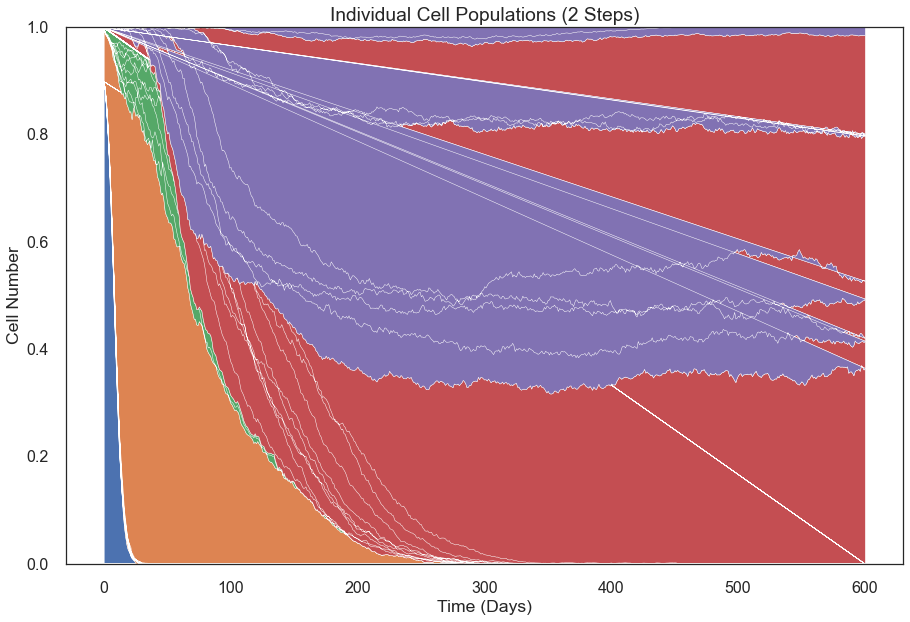

In [32]:
# One tolerant intermediary steps
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Two_Steps/'
iterations = 10
time_steps = 600
step_shan_list = []
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
res_time = []

class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())

# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = 1
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)


class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'
        self.cell_step = self.model.schedule.time

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 100
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = TolerantCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)

class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'
        self.cell_step = self.model.schedule.time

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 100
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = TolerantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)

class TolerantCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.15675),5)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = TolerantCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)

class TolerantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.15675),5)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if mut_rand < self.model.step_mut_prob and self.model.mutation == True:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)
        else:
          if self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            child = TolerantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
            self.model.grid.place_agent(child, new_pos)
            self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'

    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
        testing_list.append(self.cell_lineage)
      else:
        self.cell_lineage = self.cell_lineage
        clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
        testing_list.append(self.cell_lineage)
      else:
        self.cell_lineage = self.cell_lineage
        clone_list.append(self.cell_lineage)
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)


# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant_cells,
                 initial_tolerant_mutator_cells,
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant_cells = initial_tolerant_cells
        self.initial_tolerant_mutator_cells = initial_tolerant_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivation()
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           model_reporters={
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant Cells": lambda m: m.schedule.get_type_count(TolerantCell),
            "Tolerant Mutator Cells": lambda m: m.schedule.get_type_count(TolerantMutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            agent_reporters = 
            {"Lineage":"cell_lineage",
             "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = TolerantCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1


    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 100:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1

"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant_cells":[000],
    "initial_tolerant_mutator_cells":[0],
    "initial_resistant_cells":[000],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [3e-3*2],
    "resist_mut_prob": [0],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}
    
br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage": "cell_lineage","Cell Type": "cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Two_Steps_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + '/' + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant Cells': br_params['initial_tolerant_cells'][0],
                  'Tolerant Mutator Cells': br_params['initial_tolerant_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})
  filename = path+"/"+"Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = df['Tolerant Cells'] + df['Tolerant Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = df['Persister Mutator Cells'] + df['Tolerant Mutator Cells'] + df['Resistant Mutator Cells']
  df['Total Non-Mutator Cells'] = df['Sensitive Cells'] + df['Persister Cells'] + df['Tolerant Cells'] + df['Resistant Cells']
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant Mutator Fraction'] = df['Tolerant Mutator Cells']/df['Total Tolerant Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Non-Mutator Fraction'] = df['Total Non-Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'] + frame['Tolerant Cells'])/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'] + frame['Tolerant Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                            
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (2 Steps)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1110: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
10it [07:12, 43.22s/it]


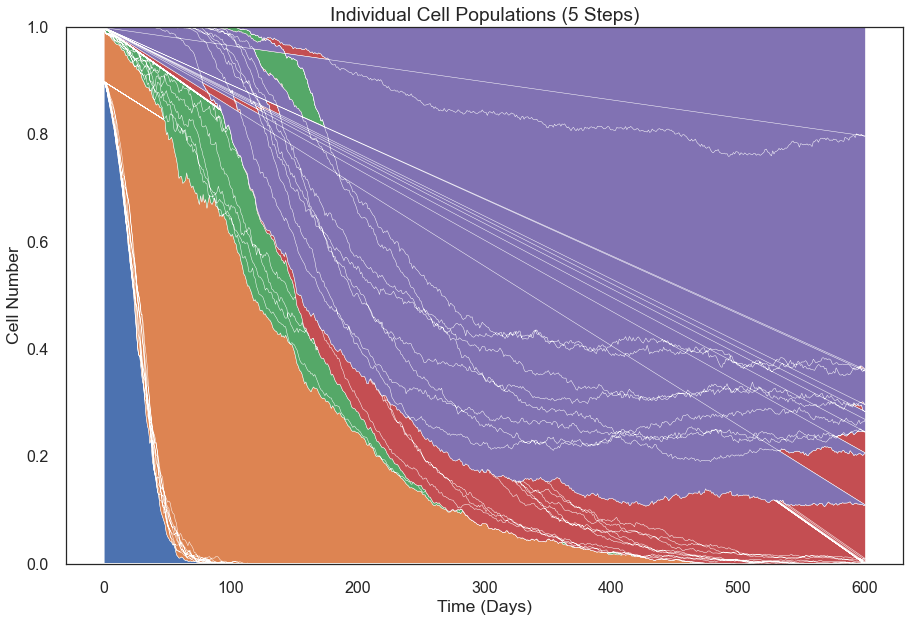

In [33]:
# 4 tolerant populations
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Five_Steps/'
iterations = 10
time_steps = 600
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
res_time = []
tol1_death = []
tol2_death = []
tol3_death = []
tol4_death = []
total_tol1_death = []
total_tol2_death = []
total_tol3_death = []
total_tol4_death = []

class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())


# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)  
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = 1
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant1Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Interemediary 1 Cell'

    def step(self):
      self.cell_type = 'Tolerant Interemediary 1 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol1_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.ccell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant1MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol1_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1681),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol2_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1681),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol2_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol3_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol3_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227), 4)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol4_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227), 4)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol4_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lienage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'
      
    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lienage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      death_rand = random.uniform(0, 1)
      clone_list.append(self.cell_lineage) 
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant1_cells,
                 initial_tolerant1_mutator_cells,
                 initial_tolerant2_cells,
                 initial_tolerant2_mutator_cells,
                 initial_tolerant3_cells,
                 initial_tolerant3_mutator_cells,
                 initial_tolerant4_cells,
                 initial_tolerant4_mutator_cells,  
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant1_cells = initial_tolerant1_cells
        self.initial_tolerant1_mutator_cells = initial_tolerant1_mutator_cells
        self.initial_tolerant2_cells = initial_tolerant2_cells
        self.initial_tolerant2_mutator_cells = initial_tolerant2_mutator_cells
        self.initial_tolerant3_cells = initial_tolerant3_cells
        self.initial_tolerant3_mutator_cells = initial_tolerant3_mutator_cells
        self.initial_tolerant4_cells = initial_tolerant4_cells
        self.initial_tolerant4_mutator_cells = initial_tolerant4_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivationByType(self)
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           {
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant1 Cells": lambda m: m.schedule.get_type_count(Tolerant1Cell),
            "Tolerant1 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant1MutatorCell),
            "Tolerant2 Cells": lambda m: m.schedule.get_type_count(Tolerant2Cell),
            "Tolerant2 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant2MutatorCell),
            "Tolerant3 Cells": lambda m: m.schedule.get_type_count(Tolerant3Cell),
            "Tolerant3 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant3MutatorCell),
            "Tolerant4 Cells": lambda m: m.schedule.get_type_count(Tolerant4Cell),
            "Tolerant4 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant4MutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            {"Lineage":"cell_lineage", "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          li = []
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
              li.append(unique_id)

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant1_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant1_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant1Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant2_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant2Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_tolerant3_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant3Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_mutator_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantMutatorCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      total_tol1_death.append(sum(tol1_death))
      total_tol2_death.append(sum(tol2_death))
      total_tol3_death.append(sum(tol3_death))
      total_tol4_death.append(sum(tol4_death))
      tol1_death.clear()
      tol2_death.clear()
      tol3_death.clear()
      tol4_death.clear()
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 100:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1


"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant1_cells":[000],
    "initial_tolerant1_mutator_cells":[0],
    "initial_tolerant2_cells":[000],
    "initial_tolerant2_mutator_cells":[0],
    "initial_tolerant3_cells":[000],
    "initial_tolerant3_mutator_cells":[0],
    "initial_tolerant4_cells":[000],
    "initial_tolerant4_mutator_cells":[0],
    "initial_resistant_cells":[0],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [0.015],
    "resist_mut_prob": [0.0000],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}

br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage": "cell_lineage","Cell Type": "cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Five_Steps_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + '/' + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant1 Cells': br_params['initial_tolerant1_cells'][0],
                  'Tolerant1 Mutator Cells': br_params['initial_tolerant1_mutator_cells'][0],
                  'Tolerant2 Cells': br_params['initial_tolerant2_cells'][0],
                  'Tolerant2 Mutator Cells': br_params['initial_tolerant2_mutator_cells'][0],
                  'Tolerant3 Cells': br_params['initial_tolerant3_cells'][0],
                  'Tolerant3 Mutator Cells': br_params['initial_tolerant3_mutator_cells'][0],
                  'Tolerant4 Cells': br_params['initial_tolerant4_cells'][0],
                  'Tolerant4 Mutator Cells': br_params['initial_tolerant4_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})
  filename = path+"/"+"Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant1 Cells'] = df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
  df['Total Tolerant2 Cells'] = df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
  df['Total Tolerant3 Cells'] = df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
  df['Total Tolerant4 Cells'] = df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = (df['Persister Mutator Cells'] + df['Tolerant1 Mutator Cells'] 
                             + df['Tolerant2 Mutator Cells'] + df['Tolerant3 Mutator Cells'] 
                             + df['Tolerant4 Mutator Cells'] 
                              + df['Resistant Mutator Cells'])
  df['Total Non-Mutator Cells'] = (df['Sensitive Cells'] + df['Persister Cells'] 
                                + df['Tolerant1 Cells'] + df['Tolerant2 Cells'] 
                                + df['Tolerant3 Cells'] +  df['Tolerant4 Cells'] 
                                + df['Resistant Cells'])
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant1 Mutator Fraction'] = df['Tolerant1 Mutator Cells']/df['Total Tolerant1 Cells']
  df['Tolerant2 Mutator Fraction'] = df['Tolerant2 Mutator Cells']/df['Total Tolerant2 Cells']
  df['Tolerant3 Mutator Fraction'] = df['Tolerant3 Mutator Cells']/df['Total Tolerant3 Cells']
  df['Tolerant4 Mutator Fraction'] = df['Tolerant4 Mutator Cells']/df['Total Tolerant4 Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = (df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
                              + df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
                              + df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
                              + df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells'])
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'] 
                                + frame['Tolerant1 Cells'] + frame['Tolerant2 Cells'] 
                                + frame['Tolerant3 Cells'] +  frame['Tolerant4 Cells'] )/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'] + frame['Tolerant1 Mutator Cells'] 
                             + frame['Tolerant2 Mutator Cells'] + frame['Tolerant3 Mutator Cells'] 
                             + frame['Tolerant4 Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                              
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (5 Steps)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1829: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
10it [06:49, 40.92s/it]


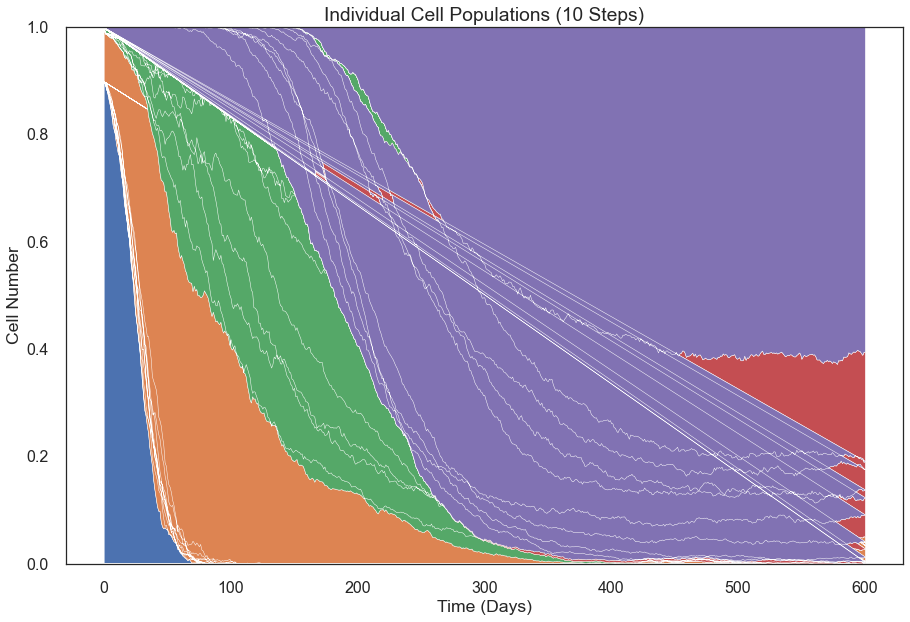

In [34]:
# 9 tolerant populations
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Ten_Steps/'
iterations = 10
time_steps = 600
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
res_time = []
tol1_death = []
tol2_death = []
tol3_death = []
tol4_death = []
tol5_death = []
tol6_death = []
tol7_death = []
tol8_death = []
tol9_death = []
total_tol1_death = []
total_tol2_death = []
total_tol3_death = []
total_tol4_death = []
total_tol5_death = []
total_tol6_death = []
total_tol7_death = []
total_tol8_death = []
total_tol9_death = []
class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())


# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)  
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = 1
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant1Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Interemediary 1 Cell'

    def step(self):
      self.cell_type = 'Tolerant Interemediary 1 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.20215), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol1_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.ccell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)



class Tolerant1MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.20215), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol1_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol2_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol2_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.17945), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol3_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.17945), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol3_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1681), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol4_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1681), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol4_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.15675), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol5_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.15675), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol5_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol6_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol6_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.13405), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol7_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.13405), 5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol7_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol8_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227), 4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol8_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant9Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.11135), 5)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol9_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant9MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.11135), 5)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        tol9_death.append(1)
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lienage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'
      
    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      death_rand = random.uniform(0, 1)
      clone_list.append(self.cell_lineage) 
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant1_cells,
                 initial_tolerant1_mutator_cells,
                 initial_tolerant2_cells,
                 initial_tolerant2_mutator_cells,
                 initial_tolerant3_cells,
                 initial_tolerant3_mutator_cells,
                 initial_tolerant4_cells,
                 initial_tolerant4_mutator_cells,
                 initial_tolerant5_cells,
                 initial_tolerant5_mutator_cells,
                 initial_tolerant6_cells,
                 initial_tolerant6_mutator_cells,
                 initial_tolerant7_cells,
                 initial_tolerant7_mutator_cells,
                 initial_tolerant8_cells,
                 initial_tolerant8_mutator_cells,
                 initial_tolerant9_cells,
                 initial_tolerant9_mutator_cells,          
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant1_cells = initial_tolerant1_cells
        self.initial_tolerant1_mutator_cells = initial_tolerant1_mutator_cells
        self.initial_tolerant2_cells = initial_tolerant2_cells
        self.initial_tolerant2_mutator_cells = initial_tolerant2_mutator_cells
        self.initial_tolerant3_cells = initial_tolerant3_cells
        self.initial_tolerant3_mutator_cells = initial_tolerant3_mutator_cells
        self.initial_tolerant4_cells = initial_tolerant4_cells
        self.initial_tolerant4_mutator_cells = initial_tolerant4_mutator_cells
        self.initial_tolerant5_cells = initial_tolerant5_cells
        self.initial_tolerant5_mutator_cells = initial_tolerant5_mutator_cells
        self.initial_tolerant6_cells = initial_tolerant6_cells
        self.initial_tolerant6_mutator_cells = initial_tolerant6_mutator_cells
        self.initial_tolerant7_cells = initial_tolerant7_cells
        self.initial_tolerant7_mutator_cells = initial_tolerant7_mutator_cells
        self.initial_tolerant8_cells = initial_tolerant8_cells
        self.initial_tolerant8_mutator_cells = initial_tolerant8_mutator_cells
        self.initial_tolerant9_cells = initial_tolerant9_cells
        self.initial_tolerant9_mutator_cells = initial_tolerant9_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivationByType(self)
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           {
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant1 Cells": lambda m: m.schedule.get_type_count(Tolerant1Cell),
            "Tolerant1 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant1MutatorCell),
            "Tolerant2 Cells": lambda m: m.schedule.get_type_count(Tolerant2Cell),
            "Tolerant2 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant2MutatorCell),
            "Tolerant3 Cells": lambda m: m.schedule.get_type_count(Tolerant3Cell),
            "Tolerant3 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant3MutatorCell),
            "Tolerant4 Cells": lambda m: m.schedule.get_type_count(Tolerant4Cell),
            "Tolerant4 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant4MutatorCell),
            "Tolerant5 Cells": lambda m: m.schedule.get_type_count(Tolerant5Cell),
            "Tolerant5 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant5MutatorCell),
            "Tolerant6 Cells": lambda m: m.schedule.get_type_count(Tolerant6Cell),
            "Tolerant6 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant6MutatorCell),
            "Tolerant7 Cells": lambda m: m.schedule.get_type_count(Tolerant7Cell),
            "Tolerant7 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant7MutatorCell),
            "Tolerant8 Cells": lambda m: m.schedule.get_type_count(Tolerant8Cell),
            "Tolerant8 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant8MutatorCell),
            "Tolerant9 Cells": lambda m: m.schedule.get_type_count(Tolerant9Cell),
            "Tolerant9 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant9MutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            {"Lineage":"cell_lineage", "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          li = []
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
              li.append(unique_id)

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant1_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant1_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant1Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant2_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant2Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_tolerant3_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant3Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_mutator_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantMutatorCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      total_tol1_death.append(sum(tol1_death))
      total_tol1_death.append(tol1_death)
      total_tol2_death.append(tol2_death)
      total_tol3_death.append(tol3_death)
      total_tol4_death.append(tol4_death)
      total_tol5_death.append(tol5_death)
      total_tol6_death.append(tol6_death)
      total_tol7_death.append(tol7_death)
      total_tol8_death.append(tol8_death)
      total_tol9_death.append(tol9_death)
      tol1_death.clear()
      tol2_death.clear()
      tol3_death.clear()
      tol4_death.clear()
      tol5_death.clear()
      tol6_death.clear()
      tol7_death.clear()
      tol8_death.clear()
      tol9_death.clear()
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 0:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1

"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant1_cells":[000],
    "initial_tolerant1_mutator_cells":[0],
    "initial_tolerant2_cells":[000],
    "initial_tolerant2_mutator_cells":[0],
    "initial_tolerant3_cells":[000],
    "initial_tolerant3_mutator_cells":[0],
    "initial_tolerant4_cells":[000],
    "initial_tolerant4_mutator_cells":[0],
    "initial_tolerant5_cells":[000],
    "initial_tolerant5_mutator_cells":[0],
    "initial_tolerant6_cells":[000],
    "initial_tolerant6_mutator_cells":[0],
    "initial_tolerant7_cells":[000],
    "initial_tolerant7_mutator_cells":[0],
    "initial_tolerant8_cells":[000],
    "initial_tolerant8_mutator_cells":[0],
    "initial_tolerant9_cells":[000],
    "initial_tolerant9_mutator_cells":[0],
    "initial_resistant_cells":[0],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [0.03],
    "resist_mut_prob": [0.0000],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}

br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage":"cell_lineage", "Cell Type":"cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Ten_Steps_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + '/' + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant1 Cells': br_params['initial_tolerant1_cells'][0],
                  'Tolerant1 Mutator Cells': br_params['initial_tolerant1_mutator_cells'][0],
                  'Tolerant2 Cells': br_params['initial_tolerant2_cells'][0],
                  'Tolerant2 Mutator Cells': br_params['initial_tolerant2_mutator_cells'][0],
                  'Tolerant3 Cells': br_params['initial_tolerant3_cells'][0],
                  'Tolerant3 Mutator Cells': br_params['initial_tolerant3_mutator_cells'][0],
                  'Tolerant4 Cells': br_params['initial_tolerant4_cells'][0],
                  'Tolerant4 Mutator Cells': br_params['initial_tolerant4_mutator_cells'][0],
                  'Tolerant5 Cells': br_params['initial_tolerant5_cells'][0],
                  'Tolerant5 Mutator Cells': br_params['initial_tolerant5_mutator_cells'][0],
                  'Tolerant6 Cells': br_params['initial_tolerant6_cells'][0],
                  'Tolerant6 Mutator Cells': br_params['initial_tolerant6_mutator_cells'][0],
                  'Tolerant7 Cells': br_params['initial_tolerant7_cells'][0],
                  'Tolerant7 Mutator Cells': br_params['initial_tolerant7_mutator_cells'][0],
                  'Tolerant8 Cells': br_params['initial_tolerant8_cells'][0],
                  'Tolerant8 Mutator Cells': br_params['initial_tolerant8_mutator_cells'][0],
                  'Tolerant9 Cells': br_params['initial_tolerant9_cells'][0],
                  'Tolerant9 Mutator Cells': br_params['initial_tolerant9_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})

  filename = path+"/"+"Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant1 Cells'] = df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
  df['Total Tolerant2 Cells'] = df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
  df['Total Tolerant3 Cells'] = df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
  df['Total Tolerant4 Cells'] = df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
  df['Total Tolerant5 Cells'] = df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
  df['Total Tolerant6 Cells'] = df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
  df['Total Tolerant7 Cells'] = df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
  df['Total Tolerant8 Cells'] = df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
  df['Total Tolerant9 Cells'] = df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = (df['Persister Mutator Cells'] + df['Tolerant1 Mutator Cells'] 
                             + df['Tolerant2 Mutator Cells'] + df['Tolerant3 Mutator Cells'] 
                             + df['Tolerant4 Mutator Cells'] + df['Tolerant5 Mutator Cells'] 
                             + df['Tolerant6 Mutator Cells'] + df['Tolerant7 Mutator Cells']
                             + df['Tolerant8 Mutator Cells'] + df['Tolerant9 Mutator Cells']  
                              + df['Resistant Mutator Cells'])
  df['Total Non-Mutator Cells'] = (df['Sensitive Cells'] + df['Persister Cells'] 
                                + df['Tolerant1 Cells'] + df['Tolerant2 Cells'] 
                                + df['Tolerant3 Cells'] +  df['Tolerant4 Cells'] 
                                + df['Tolerant5 Cells'] +  df['Tolerant6 Cells'] 
                                + df['Tolerant7 Cells'] +  df['Tolerant8 Cells'] 
                                + df['Tolerant9 Cells']  
                                + df['Resistant Cells'])
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant1 Mutator Fraction'] = df['Tolerant1 Mutator Cells']/df['Total Tolerant1 Cells']
  df['Tolerant2 Mutator Fraction'] = df['Tolerant2 Mutator Cells']/df['Total Tolerant2 Cells']
  df['Tolerant3 Mutator Fraction'] = df['Tolerant3 Mutator Cells']/df['Total Tolerant3 Cells']
  df['Tolerant4 Mutator Fraction'] = df['Tolerant4 Mutator Cells']/df['Total Tolerant4 Cells']
  df['Tolerant5 Mutator Fraction'] = df['Tolerant5 Mutator Cells']/df['Total Tolerant5 Cells']
  df['Tolerant6 Mutator Fraction'] = df['Tolerant6 Mutator Cells']/df['Total Tolerant6 Cells']
  df['Tolerant7 Mutator Fraction'] = df['Tolerant7 Mutator Cells']/df['Total Tolerant7 Cells']
  df['Tolerant8 Mutator Fraction'] = df['Tolerant8 Mutator Cells']/df['Total Tolerant8 Cells']
  df['Tolerant9 Mutator Fraction'] = df['Tolerant9 Mutator Cells']/df['Total Tolerant9 Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Non-Mutator Fraction'] = df['Total Non-Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = (df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
                              + df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
                              + df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
                              + df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
                              + df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
                              + df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
                              + df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
                              + df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
                              + df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells'])
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'] 
                                + frame['Tolerant1 Cells'] + frame['Tolerant2 Cells'] 
                                + frame['Tolerant3 Cells'] +  frame['Tolerant4 Cells'] 
                                + frame['Tolerant5 Cells'] +  frame['Tolerant6 Cells'] 
                                + frame['Tolerant7 Cells'] +  frame['Tolerant8 Cells'] 
                                + frame['Tolerant9 Cells'])/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'] + frame['Tolerant1 Mutator Cells'] 
                             + frame['Tolerant2 Mutator Cells'] + frame['Tolerant3 Mutator Cells'] 
                             + frame['Tolerant4 Mutator Cells'] + frame['Tolerant5 Mutator Cells'] 
                             + frame['Tolerant6 Mutator Cells'] + frame['Tolerant7 Mutator Cells']
                             + frame['Tolerant8 Mutator Cells'] + frame['Tolerant9 Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                              
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (10 Steps)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2486: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
10it [06:44, 40.41s/it]


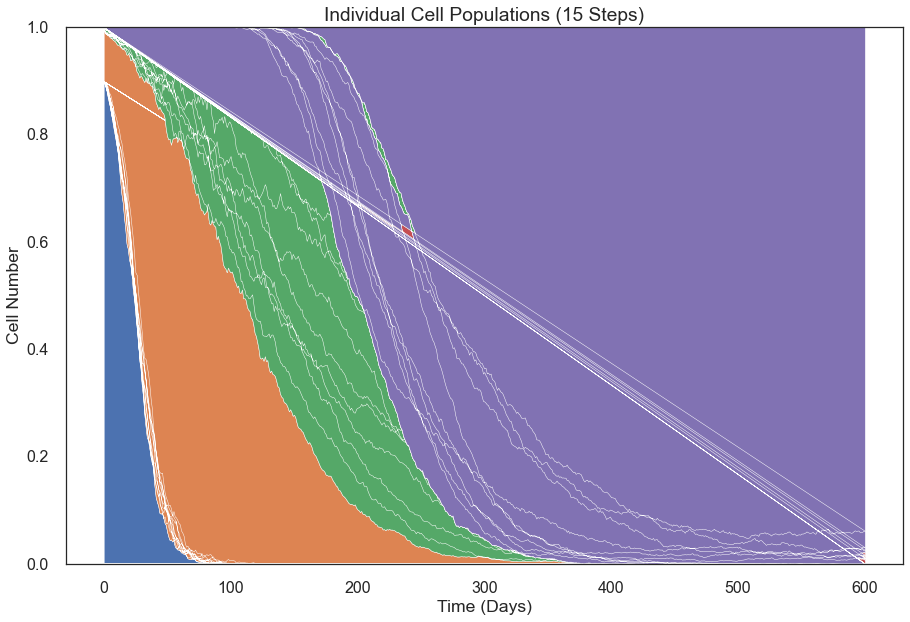

In [35]:
# 14 tolerant populations
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Fifteen_Steps/'
iterations = 10
time_steps = 600
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())


# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)  
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.2135),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant1Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Interemediary 1 Cell'

    def step(self):
      self.cell_type = 'Tolerant Interemediary 1 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.2059333333333333)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.ccell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)



class Tolerant1MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.2059333333333333)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0,  0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1983666666666668) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1983666666666668) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1908) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1908) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1832333333333334)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1832333333333334)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1756666666666666)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1756666666666666)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1681000000000001) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1681000000000001) 
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = div_rand = self.random.uniform(0.89, 1.1605333333333334)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = div_rand = self.random.uniform(0.89, 1.1605333333333334)  
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = div_rand = self.random.uniform(0.89, 1.1529666666666667)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1529666666666667)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant9Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant9MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant10Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 10 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 10 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1378333333333335)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant10MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 10 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 10 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1378333333333335)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant11Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 11 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 11 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1302666666666668)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant11MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 11 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 11 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1302666666666668)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant12Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 12 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 12 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant12MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 12 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 12 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant13Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 13 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 13 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1151333333333333)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant13MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 13 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 13 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1151333333333333)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant14Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 14 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 14 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1075666666666668)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant14MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 14 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 14 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1075666666666668)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
        
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'
      
    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell' 
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      death_rand = random.uniform(0, 1)
      clone_list.append(self.cell_lineage) 
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant1_cells,
                 initial_tolerant1_mutator_cells,
                 initial_tolerant2_cells,
                 initial_tolerant2_mutator_cells,
                 initial_tolerant3_cells,
                 initial_tolerant3_mutator_cells,
                 initial_tolerant4_cells,
                 initial_tolerant4_mutator_cells,
                 initial_tolerant5_cells,
                 initial_tolerant5_mutator_cells,
                 initial_tolerant6_cells,
                 initial_tolerant6_mutator_cells,
                 initial_tolerant7_cells,
                 initial_tolerant7_mutator_cells,
                 initial_tolerant8_cells,
                 initial_tolerant8_mutator_cells,
                 initial_tolerant9_cells,
                 initial_tolerant9_mutator_cells,
                 initial_tolerant10_cells,
                 initial_tolerant10_mutator_cells,
                 initial_tolerant11_cells,
                 initial_tolerant11_mutator_cells,
                 initial_tolerant12_cells, 
                 initial_tolerant12_mutator_cells,
                 initial_tolerant13_cells, 
                 initial_tolerant13_mutator_cells,
                 initial_tolerant14_cells, 
                 initial_tolerant14_mutator_cells,   
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant1_cells = initial_tolerant1_cells
        self.initial_tolerant1_mutator_cells = initial_tolerant1_mutator_cells
        self.initial_tolerant2_cells = initial_tolerant2_cells
        self.initial_tolerant2_mutator_cells = initial_tolerant2_mutator_cells
        self.initial_tolerant3_cells = initial_tolerant3_cells
        self.initial_tolerant3_mutator_cells = initial_tolerant3_mutator_cells
        self.initial_tolerant4_cells = initial_tolerant4_cells
        self.initial_tolerant4_mutator_cells = initial_tolerant4_mutator_cells
        self.initial_tolerant5_cells = initial_tolerant5_cells
        self.initial_tolerant5_mutator_cells = initial_tolerant5_mutator_cells
        self.initial_tolerant6_cells = initial_tolerant6_cells
        self.initial_tolerant6_mutator_cells = initial_tolerant6_mutator_cells
        self.initial_tolerant7_cells = initial_tolerant7_cells
        self.initial_tolerant7_mutator_cells = initial_tolerant7_mutator_cells
        self.initial_tolerant8_cells = initial_tolerant8_cells
        self.initial_tolerant8_mutator_cells = initial_tolerant8_mutator_cells
        self.initial_tolerant9_cells = initial_tolerant9_cells
        self.initial_tolerant9_mutator_cells = initial_tolerant9_mutator_cells
        self.initial_tolerant10_cells = initial_tolerant10_cells      
        self.initial_tolerant10_mutator_cells = initial_tolerant10_mutator_cells
        self.initial_tolerant11_cells = initial_tolerant11_cells
        self.initial_tolerant11_mutator_cells = initial_tolerant11_mutator_cells
        self.initial_tolerant12_cells = initial_tolerant12_cells
        self.initial_tolerant12_mutator_cells = initial_tolerant12_mutator_cells
        self.initial_tolerant13_cells = initial_tolerant13_cells
        self.initial_tolerant13_mutator_cells = initial_tolerant13_mutator_cells
        self.initial_tolerant14_cells = initial_tolerant14_cells
        self.initial_tolerant14_mutator_cells = initial_tolerant14_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivationByType(self)
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           {
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant1 Cells": lambda m: m.schedule.get_type_count(Tolerant1Cell),
            "Tolerant1 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant1MutatorCell),
            "Tolerant2 Cells": lambda m: m.schedule.get_type_count(Tolerant2Cell),
            "Tolerant2 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant2MutatorCell),
            "Tolerant3 Cells": lambda m: m.schedule.get_type_count(Tolerant3Cell),
            "Tolerant3 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant3MutatorCell),
            "Tolerant4 Cells": lambda m: m.schedule.get_type_count(Tolerant4Cell),
            "Tolerant4 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant4MutatorCell),
            "Tolerant5 Cells": lambda m: m.schedule.get_type_count(Tolerant5Cell),
            "Tolerant5 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant5MutatorCell),
            "Tolerant6 Cells": lambda m: m.schedule.get_type_count(Tolerant6Cell),
            "Tolerant6 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant6MutatorCell),
            "Tolerant7 Cells": lambda m: m.schedule.get_type_count(Tolerant7Cell),
            "Tolerant7 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant7MutatorCell),
            "Tolerant8 Cells": lambda m: m.schedule.get_type_count(Tolerant8Cell),
            "Tolerant8 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant8MutatorCell),
            "Tolerant9 Cells": lambda m: m.schedule.get_type_count(Tolerant9Cell),
            "Tolerant9 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant9MutatorCell),
            "Tolerant10 Cells": lambda m: m.schedule.get_type_count(Tolerant10Cell),
            "Tolerant10 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant10MutatorCell),
            "Tolerant11 Cells": lambda m: m.schedule.get_type_count(Tolerant11Cell),
            "Tolerant11 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant11MutatorCell),
            "Tolerant12 Cells": lambda m: m.schedule.get_type_count(Tolerant12Cell),
            "Tolerant12 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant12MutatorCell),
            "Tolerant13 Cells": lambda m: m.schedule.get_type_count(Tolerant13Cell),
            "Tolerant13 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant13MutatorCell),
            "Tolerant14 Cells": lambda m: m.schedule.get_type_count(Tolerant14Cell),
            "Tolerant14 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant14MutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            {"Lineage":"cell_lineage", "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          li = []
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
              li.append(unique_id)

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self, None)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant1_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant1_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant1Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant2_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant2Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_tolerant3_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant3Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_mutator_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantMutatorCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 100:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1

"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant1_cells":[000],
    "initial_tolerant1_mutator_cells":[0],
    "initial_tolerant2_cells":[000],
    "initial_tolerant2_mutator_cells":[0],
    "initial_tolerant3_cells":[000],
    "initial_tolerant3_mutator_cells":[0],
    "initial_tolerant4_cells":[000],
    "initial_tolerant4_mutator_cells":[0],
    "initial_tolerant5_cells":[000],
    "initial_tolerant5_mutator_cells":[0],
    "initial_tolerant6_cells":[000],
    "initial_tolerant6_mutator_cells":[0],
    "initial_tolerant7_cells":[000],
    "initial_tolerant7_mutator_cells":[0],
    "initial_tolerant8_cells":[000],
    "initial_tolerant8_mutator_cells":[0],
    "initial_tolerant9_cells":[000],
    "initial_tolerant9_mutator_cells":[0],
    "initial_tolerant10_cells":[000],
    "initial_tolerant10_mutator_cells":[0],
    "initial_tolerant11_cells":[000],
    "initial_tolerant11_mutator_cells":[0],
    "initial_tolerant12_cells":[000],
    "initial_tolerant12_mutator_cells":[0],
    "initial_tolerant13_cells":[000],
    "initial_tolerant13_mutator_cells":[0],
    "initial_tolerant14_cells":[000],
    "initial_tolerant14_mutator_cells":[0],
    "initial_resistant_cells":[0],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [0.045],
    "resist_mut_prob": [0.0000],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}

br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage":"cell_lineage", "Cell Type":"cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Fifteen_Steps_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + '/' + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant1 Cells': br_params['initial_tolerant1_cells'][0],
                  'Tolerant1 Mutator Cells': br_params['initial_tolerant1_mutator_cells'][0],
                  'Tolerant2 Cells': br_params['initial_tolerant2_cells'][0],
                  'Tolerant2 Mutator Cells': br_params['initial_tolerant2_mutator_cells'][0],
                  'Tolerant3 Cells': br_params['initial_tolerant3_cells'][0],
                  'Tolerant3 Mutator Cells': br_params['initial_tolerant3_mutator_cells'][0],
                  'Tolerant4 Cells': br_params['initial_tolerant4_cells'][0],
                  'Tolerant4 Mutator Cells': br_params['initial_tolerant4_mutator_cells'][0],
                  'Tolerant5 Cells': br_params['initial_tolerant5_cells'][0],
                  'Tolerant5 Mutator Cells': br_params['initial_tolerant5_mutator_cells'][0],
                  'Tolerant6 Cells': br_params['initial_tolerant6_cells'][0],
                  'Tolerant6 Mutator Cells': br_params['initial_tolerant6_mutator_cells'][0],
                  'Tolerant7 Cells': br_params['initial_tolerant7_cells'][0],
                  'Tolerant7 Mutator Cells': br_params['initial_tolerant7_mutator_cells'][0],
                  'Tolerant8 Cells': br_params['initial_tolerant8_cells'][0],
                  'Tolerant8 Mutator Cells': br_params['initial_tolerant8_mutator_cells'][0],
                  'Tolerant9 Cells': br_params['initial_tolerant9_cells'][0],
                  'Tolerant9 Mutator Cells': br_params['initial_tolerant9_mutator_cells'][0],
                  'Tolerant10 Cells': br_params['initial_tolerant10_cells'][0],
                  'Tolerant10 Mutator Cells': br_params['initial_tolerant10_mutator_cells'][0],
                  'Tolerant11 Cells': br_params['initial_tolerant11_cells'][0],
                  'Tolerant11 Mutator Cells': br_params['initial_tolerant11_mutator_cells'][0],
                  'Tolerant12 Cells': br_params['initial_tolerant12_cells'][0],
                  'Tolerant12 Mutator Cells': br_params['initial_tolerant12_mutator_cells'][0],
                  'Tolerant13 Cells': br_params['initial_tolerant13_cells'][0],
                  'Tolerant13 Mutator Cells': br_params['initial_tolerant13_mutator_cells'][0],
                  'Tolerant14 Cells': br_params['initial_tolerant14_cells'][0],
                  'Tolerant14 Mutator Cells': br_params['initial_tolerant14_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})

  filename = path+"/"+"Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant1 Cells'] = df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
  df['Total Tolerant2 Cells'] = df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
  df['Total Tolerant3 Cells'] = df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
  df['Total Tolerant4 Cells'] = df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
  df['Total Tolerant5 Cells'] = df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
  df['Total Tolerant6 Cells'] = df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
  df['Total Tolerant7 Cells'] = df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
  df['Total Tolerant8 Cells'] = df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
  df['Total Tolerant9 Cells'] = df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells']
  df['Total Tolerant10 Cells'] = df['Tolerant10 Cells'] + df['Tolerant10 Mutator Cells']
  df['Total Tolerant11 Cells'] = df['Tolerant11 Cells'] + df['Tolerant11 Mutator Cells']
  df['Total Tolerant12 Cells'] = df['Tolerant12 Cells'] + df['Tolerant12 Mutator Cells']
  df['Total Tolerant13 Cells'] = df['Tolerant13 Cells'] + df['Tolerant13 Mutator Cells']
  df['Total Tolerant14 Cells'] = df['Tolerant14 Cells'] + df['Tolerant14 Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = (df['Persister Mutator Cells'] + df['Tolerant1 Mutator Cells'] 
                             + df['Tolerant2 Mutator Cells'] + df['Tolerant3 Mutator Cells'] 
                             + df['Tolerant4 Mutator Cells'] + df['Tolerant5 Mutator Cells'] 
                             + df['Tolerant6 Mutator Cells'] + df['Tolerant7 Mutator Cells']
                             + df['Tolerant8 Mutator Cells'] + df['Tolerant9 Mutator Cells']
                             + df['Tolerant10 Mutator Cells'] + df['Tolerant11 Mutator Cells'] 
                             + df['Tolerant12 Mutator Cells'] + df['Tolerant13 Mutator Cells'] 
                             + df['Tolerant14 Mutator Cells'] + df['Resistant Mutator Cells'])
  df['Total Non-Mutator Cells'] = (df['Sensitive Cells'] + df['Persister Cells'] 
                                + df['Tolerant1 Cells'] + df['Tolerant2 Cells'] 
                                + df['Tolerant3 Cells'] +  df['Tolerant4 Cells'] 
                                + df['Tolerant5 Cells'] +  df['Tolerant6 Cells'] 
                                + df['Tolerant7 Cells'] +  df['Tolerant8 Cells'] 
                                + df['Tolerant9 Cells'] +  df['Tolerant10 Cells']
                                + df['Tolerant11 Cells'] +  df['Tolerant12 Cells']
                                + df['Tolerant13 Cells'] +  df['Tolerant14 Cells']
                                + df['Resistant Cells'])
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant1 Mutator Fraction'] = df['Tolerant1 Mutator Cells']/df['Total Tolerant1 Cells']
  df['Tolerant2 Mutator Fraction'] = df['Tolerant2 Mutator Cells']/df['Total Tolerant2 Cells']
  df['Tolerant3 Mutator Fraction'] = df['Tolerant3 Mutator Cells']/df['Total Tolerant3 Cells']
  df['Tolerant4 Mutator Fraction'] = df['Tolerant4 Mutator Cells']/df['Total Tolerant4 Cells']
  df['Tolerant5 Mutator Fraction'] = df['Tolerant5 Mutator Cells']/df['Total Tolerant5 Cells']
  df['Tolerant6 Mutator Fraction'] = df['Tolerant6 Mutator Cells']/df['Total Tolerant6 Cells']
  df['Tolerant7 Mutator Fraction'] = df['Tolerant7 Mutator Cells']/df['Total Tolerant7 Cells']
  df['Tolerant8 Mutator Fraction'] = df['Tolerant8 Mutator Cells']/df['Total Tolerant8 Cells']
  df['Tolerant9 Mutator Fraction'] = df['Tolerant9 Mutator Cells']/df['Total Tolerant9 Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Non-Mutator Fraction'] = df['Total Non-Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = (df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
                              + df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
                              + df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
                              + df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
                              + df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
                              + df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
                              + df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
                              + df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
                              + df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells']
                              + df['Tolerant10 Cells'] + df['Tolerant10 Mutator Cells']
                              + df['Tolerant11 Cells'] + df['Tolerant11 Mutator Cells']
                              + df['Tolerant12 Cells'] + df['Tolerant12 Mutator Cells']
                              + df['Tolerant13 Cells'] + df['Tolerant13 Mutator Cells']
                              + df['Tolerant14 Cells'] + df['Tolerant14 Mutator Cells'])
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'] 
                                + frame['Tolerant1 Cells'] + frame['Tolerant2 Cells'] 
                                + frame['Tolerant3 Cells'] +  frame['Tolerant4 Cells'] 
                                + frame['Tolerant5 Cells'] +  frame['Tolerant6 Cells'] 
                                + frame['Tolerant7 Cells'] +  frame['Tolerant8 Cells'] 
                                + frame['Tolerant9 Cells'] +  frame['Tolerant10 Cells']
                                + frame['Tolerant11 Cells'] +  frame['Tolerant12 Cells']
                                + frame['Tolerant13 Cells'] +  frame['Tolerant14 Cells'])/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'] + frame['Tolerant1 Mutator Cells'] 
                             + frame['Tolerant2 Mutator Cells'] + frame['Tolerant3 Mutator Cells'] 
                             + frame['Tolerant4 Mutator Cells'] + frame['Tolerant5 Mutator Cells'] 
                             + frame['Tolerant6 Mutator Cells'] + frame['Tolerant7 Mutator Cells']
                             + frame['Tolerant8 Mutator Cells'] + frame['Tolerant9 Mutator Cells']
                             + frame['Tolerant10 Mutator Cells'] + frame['Tolerant11 Mutator Cells'] 
                             + frame['Tolerant12 Mutator Cells'] + frame['Tolerant13 Mutator Cells'] 
                             + frame['Tolerant14 Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                              
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (15 Steps)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3165: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
10it [06:30, 39.08s/it]


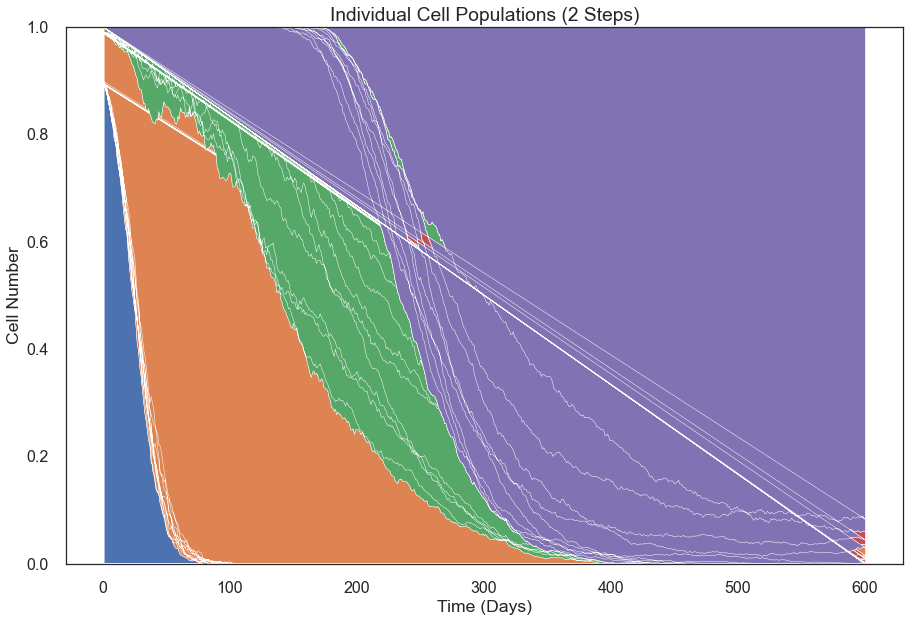

In [36]:
# 19 tolerant populations
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from scipy.stats import entropy
my_dir = '/Users/mfroid/Desktop/model_data/Twenty_Steps/'
iterations = 10
time_steps = 600
clone_list = []
step_shan_clone_list = []
model_time = []
mut_frac = 10
testing_list = []
res_time = []
class RandomActivationByType(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule
        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_type[agent_class][agent.unique_id]

    def step(self, by_type=False):
        """
        Executes the step of each agent type, one at a time, in random order.
        Args:
            by_type: If True, run all agents of a single type before running
                      the next one.
        """
        if by_type:
            for agent_class in self.agents_by_type:
                self.step_type(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_type(self, type):
        """
        Shuffle order and run all agents of a given type.
        Args:
            type: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_type[type].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_type[type][agent_key].step()

    def get_type_count(self, type_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_type[type_class].values())


# This agent is for a cell that is completely sensitive to treatment.
class SensitiveCell(Agent):
    """ An agent that can divide and reproduce. A completely sensitive cell."""
    def __init__(self, unique_id, model, cell_lineage=None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Sensitive Cell'

    def step(self):
      self.cell_type = 'Sensitive Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage)  
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.85, 1.5),2)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = SensitiveCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class PersisterCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Cell'

    def step(self):
      self.cell_type = 'Persister Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.2135)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class PersisterMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage = None):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Persister Mutator Cell'

    def step(self):
      self.cell_type = 'Persister Mutator Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.2135)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = PersisterMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant1Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Interemediary 1 Cell'

    def step(self):
      self.cell_type = 'Tolerant Interemediary 1 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.207825)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.ccell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)



class Tolerant1MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 1 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.207825)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant1MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.20215)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant2MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 2 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.20215)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant2MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.196475)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant3MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 3 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.196475)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant3MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant4MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 4 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1908),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant4MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.185125)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant5MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 5 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.185125)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant5MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.17945),5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant6MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 6 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.17945),5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant6MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.173775)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant7MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 7 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.173775)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant7MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1681000000000001)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant8MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1681000000000001)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant9Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.162425),6)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant9MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 9 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.162425),6)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant9MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant8MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant10Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 10 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 10 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1567500000000002)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant10MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 10 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 10 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1567500000000002)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant10MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant11Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 11 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 11 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.151075),6)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant11MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 11 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 11 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.151075),6)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant11MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant12Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 12 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 12 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant12MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 12 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 12 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1454),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant12MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant13Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 13 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 13 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.139725)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant13MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 13 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 13 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.139725)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant13MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant14Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 14 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 14 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.13405),5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant14MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 14 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 14 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.13405),5)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant14MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant15Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 15 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 15 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1283750000000001)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant15MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 15 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 15 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1283750000000001)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant15MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant16Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 16 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 16 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant16MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 8 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1227),4)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant16MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant17Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 17 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 17 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1170250000000002)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant17MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 17 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 17 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1170250000000002)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant17MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)


class Tolerant18Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 18 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 18 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.11135)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant18MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can survive during treatment, but does not reproduce quickly."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 18 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 18 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.11135)
      elif self.model.treatment == False:
        div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = self.random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
            elif self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if mut_rand < self.model.resist_mut_prob:
              if self.empty_neighbors:
                new_pos = self.random.choice(self.empty_neighbors)
                child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
                self.model.grid.place_agent(child, new_pos)
                self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant18MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant19Cell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 19 Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 19 Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1056750000000002)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 1)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19Cell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class Tolerant19MutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that can proliferate moderately under treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Tolerant Intermediary 19 Mutator Cell'

    def step(self):
      self.cell_type = 'Tolerant Intermediary 19 Mutator Cell'
      self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = self.random.uniform(0.89, 1.1056750000000002)
      elif self.model.treatment == False:
        div_rand = div_rand = self.random.random()
      if self.model.mutation == True:
        mut_rand = random.uniform(0, 0.25)
      elif self.model.mutation == False:
        mut_rand = 1
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if self.model.step_wise == True:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19MutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
      elif self.model.step_wise == False:
        if div_rand < self.model.div_prob and self.pos != None:
          self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
          self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
          self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
          if mut_rand < self.model.step_mut_prob:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)
          else:
            if self.empty_neighbors:
              new_pos = self.random.choice(self.empty_neighbors)
              child = Tolerant19MutatorCell(self.model.next_id(), self.model, self.cell_lienage)
              self.model.grid.place_agent(child, new_pos)
              self.model.schedule.add(child)

class ResistantCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Cell'
      
    def step(self):
      self.cell_type = 'Resistant Cell'
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      clone_list.append(self.cell_lineage) 
      death_rand = random.uniform(0, 1)
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

class ResistantMutatorCell(Agent):
    """ An agent that can divide and reproduce. A cell that is completely resistant to treatment."""
    def __init__(self, unique_id, model, cell_lineage):
        super().__init__(unique_id, model)
        self.cell_lineage = cell_lineage
        self.cell_type = 'Resistant Mutator Cell'

    def step(self):
      self.cell_type = 'Resistant Mutator Cell' 
      if self.cell_lineage == None:
        self.cell_lineage = self.unique_id
      else:
        self.cell_lineage = self.cell_lineage
      death_rand = random.uniform(0, 1)
      clone_list.append(self.cell_lineage) 
      if self.model.treatment == True:
        div_rand = round(self.random.uniform(0.89, 1.1),2)
      elif self.model.treatment == False:
        div_rand = self.random.uniform(0,1)
      if death_rand < self.model.death_prob:
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
      if div_rand < self.model.div_prob and self.pos != None:
        self.neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, radius=1)
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [c for c in self.neighborhood if self.model.grid.is_cell_empty(c)]
        if self.empty_neighbors:
          new_pos = self.random.choice(self.empty_neighbors)
          child = ResistantMutatorCell(self.model.next_id(), self.model, self.cell_lineage)
          self.model.grid.place_agent(child, new_pos)
          self.model.schedule.add(child)

# This is the model class. We can specify the grid size, the mutation rate, the division rate, and initial population sizes.
# We can also specify if we want the cells to mutate or be exposed to treatment.
class MyModel(Model):
    """A model with some number of agents."""
    verbose = False  # Print-monitoring
    def __init__(self, initial_sensitive_cells, 
                 initial_persister_cells,
                 initial_persister_mutator_cells,
                 initial_tolerant1_cells,
                 initial_tolerant1_mutator_cells,
                 initial_tolerant2_cells,
                 initial_tolerant2_mutator_cells,
                 initial_tolerant3_cells,
                 initial_tolerant3_mutator_cells,
                 initial_tolerant4_cells,
                 initial_tolerant4_mutator_cells,
                 initial_tolerant5_cells,
                 initial_tolerant5_mutator_cells,
                 initial_tolerant6_cells,
                 initial_tolerant6_mutator_cells,
                 initial_tolerant7_cells,
                 initial_tolerant7_mutator_cells,
                 initial_tolerant8_cells,
                 initial_tolerant8_mutator_cells,
                 initial_tolerant9_cells,
                 initial_tolerant9_mutator_cells,
                 initial_tolerant10_cells,
                 initial_tolerant10_mutator_cells,
                 initial_tolerant11_cells,
                 initial_tolerant11_mutator_cells,
                 initial_tolerant12_cells, 
                 initial_tolerant12_mutator_cells,
                 initial_tolerant13_cells, 
                 initial_tolerant13_mutator_cells,
                 initial_tolerant14_cells, 
                 initial_tolerant14_mutator_cells,
                 initial_tolerant15_cells, 
                 initial_tolerant15_mutator_cells,
                 initial_tolerant16_cells, 
                 initial_tolerant16_mutator_cells,
                 initial_tolerant17_cells, 
                 initial_tolerant17_mutator_cells,
                 initial_tolerant18_cells, 
                 initial_tolerant18_mutator_cells,
                 initial_tolerant19_cells, 
                 initial_tolerant19_mutator_cells,   
                 initial_resistant_cells,
                 initial_resistant_mutator_cells,
                 height, width, 
                 death_prob, 
                 div_prob, 
                 step_mut_prob,
                 resist_mut_prob, 
                 treatment, 
                 mutation,
                 step_wise,
                 mutators,
                 rand_mutators):
      
        super().__init__()
        self.initial_sensitive_cells = initial_sensitive_cells
        self.initial_persister_cells = initial_persister_cells
        self.initial_persister_mutator_cells = initial_persister_mutator_cells
        self.initial_tolerant1_cells = initial_tolerant1_cells
        self.initial_tolerant1_mutator_cells = initial_tolerant1_mutator_cells
        self.initial_tolerant2_cells = initial_tolerant2_cells
        self.initial_tolerant2_mutator_cells = initial_tolerant2_mutator_cells
        self.initial_tolerant3_cells = initial_tolerant3_cells
        self.initial_tolerant3_mutator_cells = initial_tolerant3_mutator_cells
        self.initial_tolerant4_cells = initial_tolerant4_cells
        self.initial_tolerant4_mutator_cells = initial_tolerant4_mutator_cells
        self.initial_tolerant5_cells = initial_tolerant5_cells
        self.initial_tolerant5_mutator_cells = initial_tolerant5_mutator_cells
        self.initial_tolerant6_cells = initial_tolerant6_cells
        self.initial_tolerant6_mutator_cells = initial_tolerant6_mutator_cells
        self.initial_tolerant7_cells = initial_tolerant7_cells
        self.initial_tolerant7_mutator_cells = initial_tolerant7_mutator_cells
        self.initial_tolerant8_cells = initial_tolerant8_cells
        self.initial_tolerant8_mutator_cells = initial_tolerant8_mutator_cells
        self.initial_tolerant9_cells = initial_tolerant9_cells
        self.initial_tolerant9_mutator_cells = initial_tolerant9_mutator_cells
        self.initial_tolerant10_cells = initial_tolerant10_cells      
        self.initial_tolerant10_mutator_cells = initial_tolerant10_mutator_cells
        self.initial_tolerant11_cells = initial_tolerant11_cells
        self.initial_tolerant11_mutator_cells = initial_tolerant11_mutator_cells
        self.initial_tolerant12_cells = initial_tolerant12_cells
        self.initial_tolerant12_mutator_cells = initial_tolerant12_mutator_cells
        self.initial_tolerant13_cells = initial_tolerant13_cells
        self.initial_tolerant13_mutator_cells = initial_tolerant13_mutator_cells
        self.initial_tolerant14_cells = initial_tolerant14_cells
        self.initial_tolerant14_mutator_cells = initial_tolerant14_mutator_cells
        self.initial_tolerant15_cells = initial_tolerant15_cells
        self.initial_tolerant15_mutator_cells = initial_tolerant15_mutator_cells
        self.initial_tolerant16_cells = initial_tolerant16_cells
        self.initial_tolerant16_mutator_cells = initial_tolerant16_mutator_cells
        self.initial_tolerant117_cells = initial_tolerant17_cells
        self.initial_tolerant17_mutator_cells = initial_tolerant17_mutator_cells
        self.initial_tolerant18_cells = initial_tolerant18_cells
        self.initial_tolerant18_mutator_cells = initial_tolerant18_mutator_cells
        self.initial_tolerant19_cells = initial_tolerant19_cells
        self.initial_tolerant19_mutator_cells = initial_tolerant19_mutator_cells
        self.initial_resistant_cells = initial_resistant_cells
        self.initial_resistant_mutator_cells = initial_resistant_mutator_cells
        self.height = height
        self.width = width
        self.death_prob = death_prob
        self.div_prob = div_prob
        self.step_mut_prob = step_mut_prob
        self.resist_mut_prob = resist_mut_prob
        self.treatment = treatment
        self.mutation = mutation
        self.step_wise = step_wise
        self.mutators = mutators
        self.rand_mutators = rand_mutators
        self.schedule = RandomActivationByType(self)
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
           {
            "Sensitive Cells": lambda m: m.schedule.get_type_count(SensitiveCell),
            "Persister Cells": lambda m: m.schedule.get_type_count(PersisterCell),
            "Persister Mutator Cells": lambda m: m.schedule.get_type_count(PersisterMutatorCell),
            "Tolerant1 Cells": lambda m: m.schedule.get_type_count(Tolerant1Cell),
            "Tolerant1 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant1MutatorCell),
            "Tolerant2 Cells": lambda m: m.schedule.get_type_count(Tolerant2Cell),
            "Tolerant2 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant2MutatorCell),
            "Tolerant3 Cells": lambda m: m.schedule.get_type_count(Tolerant3Cell),
            "Tolerant3 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant3MutatorCell),
            "Tolerant4 Cells": lambda m: m.schedule.get_type_count(Tolerant4Cell),
            "Tolerant4 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant4MutatorCell),
            "Tolerant5 Cells": lambda m: m.schedule.get_type_count(Tolerant5Cell),
            "Tolerant5 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant5MutatorCell),
            "Tolerant6 Cells": lambda m: m.schedule.get_type_count(Tolerant6Cell),
            "Tolerant6 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant6MutatorCell),
            "Tolerant7 Cells": lambda m: m.schedule.get_type_count(Tolerant7Cell),
            "Tolerant7 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant7MutatorCell),
            "Tolerant8 Cells": lambda m: m.schedule.get_type_count(Tolerant8Cell),
            "Tolerant8 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant8MutatorCell),
            "Tolerant9 Cells": lambda m: m.schedule.get_type_count(Tolerant9Cell),
            "Tolerant9 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant9MutatorCell),
            "Tolerant10 Cells": lambda m: m.schedule.get_type_count(Tolerant10Cell),
            "Tolerant10 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant10MutatorCell),
            "Tolerant11 Cells": lambda m: m.schedule.get_type_count(Tolerant11Cell),
            "Tolerant11 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant11MutatorCell),
            "Tolerant12 Cells": lambda m: m.schedule.get_type_count(Tolerant12Cell),
            "Tolerant12 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant12MutatorCell),
            "Tolerant13 Cells": lambda m: m.schedule.get_type_count(Tolerant13Cell),
            "Tolerant13 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant13MutatorCell),
            "Tolerant14 Cells": lambda m: m.schedule.get_type_count(Tolerant14Cell),
            "Tolerant14 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant14MutatorCell),
            "Tolerant15 Cells": lambda m: m.schedule.get_type_count(Tolerant15Cell),
            "Tolerant15 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant15MutatorCell),
            "Tolerant16 Cells": lambda m: m.schedule.get_type_count(Tolerant16Cell),
            "Tolerant16 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant16MutatorCell),
            "Tolerant17 Cells": lambda m: m.schedule.get_type_count(Tolerant17Cell),
            "Tolerant17 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant17MutatorCell),
            "Tolerant18 Cells": lambda m: m.schedule.get_type_count(Tolerant18Cell),
            "Tolerant18 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant18MutatorCell),
            "Tolerant19 Cells": lambda m: m.schedule.get_type_count(Tolerant19Cell),
            "Tolerant19 Mutator Cells": lambda m: m.schedule.get_type_count(Tolerant19MutatorCell),
            "Resistant Cells": lambda m: m.schedule.get_type_count(ResistantCell),
            "Resistant Mutator Cells": lambda m: m.schedule.get_type_count(ResistantMutatorCell)
            },
            {"Lineage":"cell_lineage", "Cell Type":"cell_type"}
        )

        if self.initial_sensitive_cells > 0:
          unique_id = 0
          li = []
          while True:
            if unique_id == self.initial_sensitive_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = SensitiveCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
              li.append(unique_id)

        if self.initial_persister_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_persister_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if unique_id % self.initial_persister_mutator_cells == 0 and self.mutators == True:
              if self.grid.is_cell_empty((x,y)) == True:
                cell = PersisterMutatorCell(self.next_id(), self, None)
                self.grid.place_agent(cell, (x,y))
                self.schedule.add(cell)
                unique_id +=1
            elif self.grid.is_cell_empty((x,y)) == True:
              cell = PersisterCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant1_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant1_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant1Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_tolerant2_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant2Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1
        
        if self.initial_tolerant3_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_tolerant2_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = Tolerant3Cell(self.next_id(), self)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

        if self.initial_resistant_mutator_cells > 0:
          unique_id = 0
          while True:
            if unique_id == self.initial_resistant_cells:
              break
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            pos = (x,y)
            if self.grid.is_cell_empty((x,y)) == True:
              cell = ResistantMutatorCell(self.next_id(), self, None)
              self.grid.place_agent(cell, (x,y))
              self.schedule.add(cell)
              unique_id +=1

    def step(self):
      global clone_list
      global testing_list
      self.schedule.step()
      self.datacollector.collect(self)
      model_time.append(self.schedule.time)
      for i in testing_list:
        clone_list = [x for x in clone_list if x!= i]
      new_data = pd.Series(clone_list)
      p_data = new_data.value_counts()
      ent = entropy(p_data)
      step_shan_clone_list.append(ent)
      clone_list.clear()      
      if self.rand_mutators == True:
        if self.schedule.time == 100:
          num_res = 3
          unique_id = 0
          while True:
            if unique_id == num_res:
              break
            else:
              x = self.random.randrange(self.width)
              y = self.random.randrange(self.height)
              pos = (x,y)
              if self.grid.is_cell_empty((x,y)) == True:
                cell = ResistantCell(self.next_id(), self, None)
                self.grid.place_agent(cell, pos)
                self.schedule.add(cell)
                unique_id +=1

"""
Below is the section for hyperparameter tuning and producing graphs.
For each iteration a CSV file is produced, with the results for that iteration.
After all iterations, every dataframe generated per iteration is appended into one.
"""
# This section allows us to do a parameter sweep, save the iteration(s) as a csv, and then plot the results.
br_params = {
    "initial_sensitive_cells": [9000],
    "initial_persister_cells":[1000],
    "initial_persister_mutator_cells":[mut_frac],
    "initial_tolerant1_cells":[000],
    "initial_tolerant1_mutator_cells":[0],
    "initial_tolerant2_cells":[000],
    "initial_tolerant2_mutator_cells":[0],
    "initial_tolerant3_cells":[000],
    "initial_tolerant3_mutator_cells":[0],
    "initial_tolerant4_cells":[000],
    "initial_tolerant4_mutator_cells":[0],
    "initial_tolerant5_cells":[000],
    "initial_tolerant5_mutator_cells":[0],
    "initial_tolerant6_cells":[000],
    "initial_tolerant6_mutator_cells":[0],
    "initial_tolerant7_cells":[000],
    "initial_tolerant7_mutator_cells":[0],
    "initial_tolerant8_cells":[000],
    "initial_tolerant8_mutator_cells":[0],
    "initial_tolerant9_cells":[000],
    "initial_tolerant9_mutator_cells":[0],
    "initial_tolerant10_cells":[000],
    "initial_tolerant10_mutator_cells":[0],
    "initial_tolerant11_cells":[000],
    "initial_tolerant11_mutator_cells":[0],
    "initial_tolerant12_cells":[000],
    "initial_tolerant12_mutator_cells":[0],
    "initial_tolerant13_cells":[000],
    "initial_tolerant13_mutator_cells":[0],
    "initial_tolerant14_cells":[000],
    "initial_tolerant14_mutator_cells":[0],
    "initial_tolerant15_cells":[000],
    "initial_tolerant15_mutator_cells":[0],
    "initial_tolerant16_cells":[000],
    "initial_tolerant16_mutator_cells":[0],
    "initial_tolerant17_cells":[000],
    "initial_tolerant17_mutator_cells":[0],
    "initial_tolerant18_cells":[000],
    "initial_tolerant18_mutator_cells":[0],
    "initial_tolerant19_cells":[000],
    "initial_tolerant19_mutator_cells":[0],
    "initial_resistant_cells":[0],
    "initial_resistant_mutator_cells":[0],
    "height":[100],
    "width":[100],
    "div_prob": [1.0],
    "death_prob": [0.25], #best baseline is 0.26
    "step_mut_prob": [0.06],
    "resist_mut_prob": [0.0000],
    "treatment":[True],
    "mutation":[True],
    "step_wise":[True],
    "mutators":[True],
    "rand_mutators":[False]}

br = BatchRunner(
    MyModel,
    br_params,
    iterations=iterations,
    max_steps = time_steps,
    model_reporters = {"Data Collector": lambda m: m.datacollector},
    agent_reporters = {"Lineage":"cell_lineage", "Cell Type":"cell_type"})

date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
path = my_dir + 'Twenty_Steps_' + str(date)
os.mkdir(path)
br.run_all()
br_df = br.get_model_vars_dataframe()
#br_agent_df = br.get_agent_vars_dataframe()
for i in range(len(br_df["Data Collector"])):
  br_step_data = pd.DataFrame()
  if isinstance(br_df["Data Collector"][i], DataCollector):
    i_run_data = br_df["Data Collector"][i].get_model_vars_dataframe()
    br_step_data = br_step_data.append(i_run_data, ignore_index=True)
    br_step_data.to_csv(path + '/' + "Model_Data_"+str(i)+".csv")
li = []
for i in range(br.iterations):
  data = []
  data.insert(0, {'Unnamed: 0': 0, 
                  'Sensitive Cells': br_params['initial_sensitive_cells'][0], 
                  'Persister Cells': br_params['initial_persister_cells'][0],
                  'Persister Mutator Cells': br_params['initial_persister_mutator_cells'][0],  
                  'Tolerant1 Cells': br_params['initial_tolerant1_cells'][0],
                  'Tolerant1 Mutator Cells': br_params['initial_tolerant1_mutator_cells'][0],
                  'Tolerant2 Cells': br_params['initial_tolerant2_cells'][0],
                  'Tolerant2 Mutator Cells': br_params['initial_tolerant2_mutator_cells'][0],
                  'Tolerant3 Cells': br_params['initial_tolerant3_cells'][0],
                  'Tolerant3 Mutator Cells': br_params['initial_tolerant3_mutator_cells'][0],
                  'Tolerant4 Cells': br_params['initial_tolerant4_cells'][0],
                  'Tolerant4 Mutator Cells': br_params['initial_tolerant4_mutator_cells'][0],
                  'Tolerant5 Cells': br_params['initial_tolerant5_cells'][0],
                  'Tolerant5 Mutator Cells': br_params['initial_tolerant5_mutator_cells'][0],
                  'Tolerant6 Cells': br_params['initial_tolerant6_cells'][0],
                  'Tolerant6 Mutator Cells': br_params['initial_tolerant6_mutator_cells'][0],
                  'Tolerant7 Cells': br_params['initial_tolerant7_cells'][0],
                  'Tolerant7 Mutator Cells': br_params['initial_tolerant7_mutator_cells'][0],
                  'Tolerant8 Cells': br_params['initial_tolerant8_cells'][0],
                  'Tolerant8 Mutator Cells': br_params['initial_tolerant8_mutator_cells'][0],
                  'Tolerant9 Cells': br_params['initial_tolerant9_cells'][0],
                  'Tolerant9 Mutator Cells': br_params['initial_tolerant9_mutator_cells'][0],
                  'Tolerant10 Cells': br_params['initial_tolerant10_cells'][0],
                  'Tolerant10 Mutator Cells': br_params['initial_tolerant10_mutator_cells'][0],
                  'Tolerant11 Cells': br_params['initial_tolerant11_cells'][0],
                  'Tolerant11 Mutator Cells': br_params['initial_tolerant11_mutator_cells'][0],
                  'Tolerant12 Cells': br_params['initial_tolerant12_cells'][0],
                  'Tolerant12 Mutator Cells': br_params['initial_tolerant12_mutator_cells'][0],
                  'Tolerant13 Cells': br_params['initial_tolerant13_cells'][0],
                  'Tolerant13 Mutator Cells': br_params['initial_tolerant13_mutator_cells'][0],
                  'Tolerant14 Cells': br_params['initial_tolerant14_cells'][0],
                  'Tolerant14 Mutator Cells': br_params['initial_tolerant14_mutator_cells'][0],
                  'Tolerant15 Cells': br_params['initial_tolerant15_cells'][0],
                  'Tolerant15 Mutator Cells': br_params['initial_tolerant15_mutator_cells'][0],
                  'Tolerant16 Cells': br_params['initial_tolerant16_cells'][0],
                  'Tolerant16 Mutator Cells': br_params['initial_tolerant16_mutator_cells'][0],
                  'Tolerant17 Cells': br_params['initial_tolerant17_cells'][0],
                  'Tolerant17 Mutator Cells': br_params['initial_tolerant17_mutator_cells'][0],
                  'Tolerant18 Cells': br_params['initial_tolerant18_cells'][0],
                  'Tolerant18 Mutator Cells': br_params['initial_tolerant18_mutator_cells'][0],
                  'Tolerant19 Cells': br_params['initial_tolerant19_cells'][0],
                  'Tolerant19 Mutator Cells': br_params['initial_tolerant19_mutator_cells'][0],
                  'Resistant Cells': br_params['initial_resistant_cells'][0],
                  'Resistant Mutator Cells': br_params['initial_resistant_mutator_cells'][0]})

  filename = path + "/" + "Model_Data_"+str(i)+".csv"
  df = pd.read_csv(filename, index_col=None, header=0)
  df['Unnamed: 0'] += 1
  df['Time'] = df['Unnamed: 0']
  del df['Unnamed: 0']
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant1 Cells'] = df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
  df['Total Tolerant2 Cells'] = df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
  df['Total Tolerant3 Cells'] = df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
  df['Total Tolerant4 Cells'] = df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
  df['Total Tolerant5 Cells'] = df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
  df['Total Tolerant6 Cells'] = df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
  df['Total Tolerant7 Cells'] = df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
  df['Total Tolerant8 Cells'] = df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
  df['Total Tolerant9 Cells'] = df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells']
  df['Total Tolerant10 Cells'] = df['Tolerant10 Cells'] + df['Tolerant10 Mutator Cells']
  df['Total Tolerant11 Cells'] = df['Tolerant11 Cells'] + df['Tolerant11 Mutator Cells']
  df['Total Tolerant12 Cells'] = df['Tolerant12 Cells'] + df['Tolerant12 Mutator Cells']
  df['Total Tolerant13 Cells'] = df['Tolerant13 Cells'] + df['Tolerant13 Mutator Cells']
  df['Total Tolerant14 Cells'] = df['Tolerant14 Cells'] + df['Tolerant14 Mutator Cells']
  df['Total Tolerant15 Cells'] = df['Tolerant15 Cells'] + df['Tolerant15 Mutator Cells']
  df['Total Tolerant16 Cells'] = df['Tolerant16 Cells'] + df['Tolerant16 Mutator Cells']
  df['Total Tolerant17 Cells'] = df['Tolerant17 Cells'] + df['Tolerant17 Mutator Cells']
  df['Total Tolerant18 Cells'] = df['Tolerant18 Cells'] + df['Tolerant18 Mutator Cells']
  df['Total Tolerant19 Cells'] = df['Tolerant19 Cells'] + df['Tolerant19 Mutator Cells']
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  df['Total Mutator Cells'] = (df['Persister Mutator Cells'] + df['Tolerant1 Mutator Cells'] 
                             + df['Tolerant2 Mutator Cells'] + df['Tolerant3 Mutator Cells'] 
                             + df['Tolerant4 Mutator Cells'] + df['Tolerant5 Mutator Cells'] 
                             + df['Tolerant6 Mutator Cells'] + df['Tolerant7 Mutator Cells']
                             + df['Tolerant8 Mutator Cells'] + df['Tolerant9 Mutator Cells']
                             + df['Tolerant10 Mutator Cells'] + df['Tolerant11 Mutator Cells'] 
                             + df['Tolerant12 Mutator Cells'] + df['Tolerant13 Mutator Cells'] 
                             + df['Tolerant14 Mutator Cells'] + df['Tolerant15 Mutator Cells'] 
                             + df['Tolerant16 Mutator Cells'] + df['Tolerant17 Mutator Cells'] 
                             + df['Tolerant18 Mutator Cells'] + df['Tolerant19 Mutator Cells'] 
                             + df['Resistant Mutator Cells'])
  df['Total Non-Mutator Cells'] = (df['Sensitive Cells'] + df['Persister Cells'] 
                                + df['Tolerant1 Cells'] + df['Tolerant2 Cells'] 
                                + df['Tolerant3 Cells'] +  df['Tolerant4 Cells'] 
                                + df['Tolerant5 Cells'] +  df['Tolerant6 Cells'] 
                                + df['Tolerant7 Cells'] +  df['Tolerant8 Cells'] 
                                + df['Tolerant9 Cells'] +  df['Tolerant10 Cells']
                                + df['Tolerant11 Cells'] +  df['Tolerant12 Cells']
                                + df['Tolerant13 Cells'] +  df['Tolerant14 Cells']
                                + df['Tolerant15 Cells'] +  df['Tolerant16 Cells']
                                + df['Tolerant17 Cells'] +  df['Tolerant18 Cells']
                                + df['Tolerant19 Cells']
                                + df['Resistant Cells'])
  df['Persister Mutator Fraction'] = df['Persister Mutator Cells']/df['Total Persister Cells']
  df['Tolerant1 Mutator Fraction'] = df['Tolerant1 Mutator Cells']/df['Total Tolerant1 Cells']
  df['Tolerant2 Mutator Fraction'] = df['Tolerant2 Mutator Cells']/df['Total Tolerant2 Cells']
  df['Tolerant3 Mutator Fraction'] = df['Tolerant3 Mutator Cells']/df['Total Tolerant3 Cells']
  df['Tolerant4 Mutator Fraction'] = df['Tolerant4 Mutator Cells']/df['Total Tolerant4 Cells']
  df['Tolerant5 Mutator Fraction'] = df['Tolerant5 Mutator Cells']/df['Total Tolerant5 Cells']
  df['Tolerant6 Mutator Fraction'] = df['Tolerant6 Mutator Cells']/df['Total Tolerant6 Cells']
  df['Tolerant7 Mutator Fraction'] = df['Tolerant7 Mutator Cells']/df['Total Tolerant7 Cells']
  df['Tolerant8 Mutator Fraction'] = df['Tolerant8 Mutator Cells']/df['Total Tolerant8 Cells']
  df['Tolerant9 Mutator Fraction'] = df['Tolerant9 Mutator Cells']/df['Total Tolerant9 Cells']
  df['Resistant Mutator Fraction'] = df['Resistant Mutator Cells']/df['Total Resistant Cells']
  df['Total Mutator Fraction'] = df['Total Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Non-Mutator Fraction'] = df['Total Non-Mutator Cells']/(df['Total Non-Mutator Cells'] + df['Total Mutator Cells'])
  df['Total Population'] = (df['Total Mutator Cells'] + df['Total Non-Mutator Cells'])
  df['Total Persister Cells'] = df['Persister Cells'] + df['Persister Mutator Cells']
  df['Total Tolerant Cells'] = (df['Tolerant1 Cells'] + df['Tolerant1 Mutator Cells']
                              + df['Tolerant2 Cells'] + df['Tolerant2 Mutator Cells']
                              + df['Tolerant3 Cells'] + df['Tolerant3 Mutator Cells']
                              + df['Tolerant4 Cells'] + df['Tolerant4 Mutator Cells']
                              + df['Tolerant5 Cells'] + df['Tolerant5 Mutator Cells']
                              + df['Tolerant6 Cells'] + df['Tolerant6 Mutator Cells']
                              + df['Tolerant7 Cells'] + df['Tolerant7 Mutator Cells']
                              + df['Tolerant8 Cells'] + df['Tolerant8 Mutator Cells']
                              + df['Tolerant9 Cells'] + df['Tolerant9 Mutator Cells']
                              + df['Tolerant10 Cells'] + df['Tolerant10 Mutator Cells']
                              + df['Tolerant11 Cells'] + df['Tolerant11 Mutator Cells']
                              + df['Tolerant12 Cells'] + df['Tolerant12 Mutator Cells']
                              + df['Tolerant13 Cells'] + df['Tolerant13 Mutator Cells']
                              + df['Tolerant14 Cells'] + df['Tolerant14 Mutator Cells']
                              + df['Tolerant15 Cells'] + df['Tolerant15 Mutator Cells']
                              + df['Tolerant16 Cells'] + df['Tolerant16 Mutator Cells']
                              + df['Tolerant17 Cells'] + df['Tolerant17 Mutator Cells']
                              + df['Tolerant18 Cells'] + df['Tolerant18 Mutator Cells']
                              + df['Tolerant19 Cells'] + df['Tolerant19 Mutator Cells'])
  df['Total Resistant Cells'] = df['Resistant Cells'] + df['Resistant Mutator Cells']
  li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.fillna(0)
frame.to_csv(path + '/' + "Processed_Data.csv")
frame['Sensitive Frac'] = frame['Sensitive Cells']/frame['Total Population']
frame['Persister Frac'] = (frame['Persister Cells'] 
                                + frame['Tolerant1 Cells'] + frame['Tolerant2 Cells'] 
                                + frame['Tolerant3 Cells'] +  frame['Tolerant4 Cells'] 
                                + frame['Tolerant5 Cells'] +  frame['Tolerant6 Cells'] 
                                + frame['Tolerant7 Cells'] +  frame['Tolerant8 Cells'] 
                                + frame['Tolerant9 Cells'] +  frame['Tolerant10 Cells']
                                + frame['Tolerant11 Cells'] +  frame['Tolerant12 Cells']
                                + frame['Tolerant13 Cells'] +  frame['Tolerant14 Cells']
                                + frame['Tolerant15 Cells'] +  frame['Tolerant16 Cells']
                                + frame['Tolerant17 Cells'] +  frame['Tolerant18 Cells']
                                + frame['Tolerant19 Cells'])/frame['Total Population']
frame['Mutator Frac'] = (frame['Persister Mutator Cells'] + frame['Tolerant1 Mutator Cells'] 
                             + frame['Tolerant2 Mutator Cells'] + frame['Tolerant3 Mutator Cells'] 
                             + frame['Tolerant4 Mutator Cells'] + frame['Tolerant5 Mutator Cells'] 
                             + frame['Tolerant6 Mutator Cells'] + frame['Tolerant7 Mutator Cells']
                             + frame['Tolerant8 Mutator Cells'] + frame['Tolerant9 Mutator Cells']
                             + frame['Tolerant10 Mutator Cells'] + frame['Tolerant11 Mutator Cells'] 
                             + frame['Tolerant12 Mutator Cells'] + frame['Tolerant13 Mutator Cells'] 
                             + frame['Tolerant14 Mutator Cells'] + frame['Tolerant15 Mutator Cells'] 
                             + frame['Tolerant16 Mutator Cells'] + frame['Tolerant17 Mutator Cells'] 
                             + frame['Tolerant18 Mutator Cells'] + frame['Tolerant19 Mutator Cells'])/frame['Total Population']
frame['Resistant Frac'] = frame['Resistant Cells']/frame['Total Population']
frame['Resistant Mutator Frac'] = frame['Resistant Mutator Cells']/frame['Total Population']                              
#sns.set(rc = {'figure.figsize':(10,10)})
sns.set(style='white', font_scale = 1)
#plt.figure(figsize=(10,10))
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.stackplot(frame['Time'], frame['Sensitive Frac'],
              frame['Persister Frac'], 
              frame['Mutator Frac'],
              frame['Resistant Frac'],
              frame['Resistant Mutator Frac'])
plt.xlabel('Time (Days)') # X axis data label
plt.ylabel('Cell Number') # Y axis data label
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Individual Cell Populations (2 Steps)')
plt.style.use('seaborn-poster')
plt.tight_layout()
plt.show()
%reset -f  